# COMP47590: Advanced Machine Learning
# Assignment 2: Pneumonia Detection 

Name(s): Li Weijing

Student Number(s): 19204246

## Import Packages Etc

In [2]:
import random
import cv2
import os
import numpy as np
import pandas as pd
import scipy as sp
from keras.applications import VGG16

import sklearn
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import skimage
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

## Task 1： Load the chest x-ray dataset and become familiar with its contents. 

In [3]:
#dataset_name & path
dataset_name = 'chest_xray'

train_data_dir = dataset_name + '/train/'
test_data_dir = dataset_name + '/test/'

#set up the sample_rate for data loading
sample_rate = 1.0

#set width and height
img_width, img_height = 162, 128
input_shape=(img_width, img_height)

In [4]:
'''
Load figures from the path, resize the shape(162*182) of it and 
convert the images to greyscale.
'''
def load_data(path):
    training_class_folders = [i for i in os.listdir(path) if not i.startswith('.')] # use this for full dataset
    print(path)
    
    # Initialise arrays for data storage
    X_data = np.ndarray((0, input_shape[0], input_shape[1]), dtype=np.float)
    y_data= np.ndarray(0, dtype=np.str)
    
    #loop through the folders: NORMAL and PNEUMONIA
    for i, image_cls in enumerate(training_class_folders):
        print('Processing class',(image_cls))
        image_class_folder = path + image_cls + "/"

        image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
        image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

        count = len(image_filenames)
        X_data_part = np.ndarray((count, input_shape[0], input_shape[1]), dtype=np.float)
        
        #loop through the images in the data folder.
        for i, image_file in enumerate(image_filenames):
            
            # convert the image to greyscale.
            image = cv2.imread(image_file, 0)
            # resize the image 
            image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
            
            # add data to the array and normalise
            X_data_part[i] = image
            X_data_part[i] = X_data_part[i]/255
            y_data = np.append(y_data, image_cls)
        
            if i%300 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

        print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
        X_data = np.append(X_data, X_data_part, axis=0)
    print("Data shape: {}".format(X_data.shape))
    return (X_data,y_data)

In [5]:
# load train data
(X_train,y_train)=load_data(train_data_dir)

chest_xray/train/
Processing class NORMAL
Processed 0 of 1349 for class NORMAL 
Processed 300 of 1349 for class NORMAL 
Processed 600 of 1349 for class NORMAL 
Processed 900 of 1349 for class NORMAL 
Processed 1200 of 1349 for class NORMAL 
Processed 1349 of 1349 for class NORMAL 
Processing class PNEUMONIA
Processed 0 of 3883 for class PNEUMONIA 
Processed 300 of 3883 for class PNEUMONIA 
Processed 600 of 3883 for class PNEUMONIA 
Processed 900 of 3883 for class PNEUMONIA 
Processed 1200 of 3883 for class PNEUMONIA 
Processed 1500 of 3883 for class PNEUMONIA 
Processed 1800 of 3883 for class PNEUMONIA 
Processed 2100 of 3883 for class PNEUMONIA 
Processed 2400 of 3883 for class PNEUMONIA 
Processed 2700 of 3883 for class PNEUMONIA 
Processed 3000 of 3883 for class PNEUMONIA 
Processed 3300 of 3883 for class PNEUMONIA 
Processed 3600 of 3883 for class PNEUMONIA 
Processed 3883 of 3883 for class PNEUMONIA 
Data shape: (5232, 162, 128)


In [6]:
# load test data
(X_test,y_test)=load_data(test_data_dir)

chest_xray/test/
Processing class NORMAL
Processed 0 of 234 for class NORMAL 
Processed 234 of 234 for class NORMAL 
Processing class PNEUMONIA
Processed 0 of 390 for class PNEUMONIA 
Processed 300 of 390 for class PNEUMONIA 
Processed 390 of 390 for class PNEUMONIA 
Data shape: (624, 162, 128)


In [7]:
# Convert class vectors to binary class matrices.

num_classes = 2

y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

classes_num_label = dict()
for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl
print(classes_num_label)
print(X_train.shape,y_train.shape)

{0: 'NORMAL', 1: 'PNEUMONIA'}
(5232, 162, 128) (5232,)


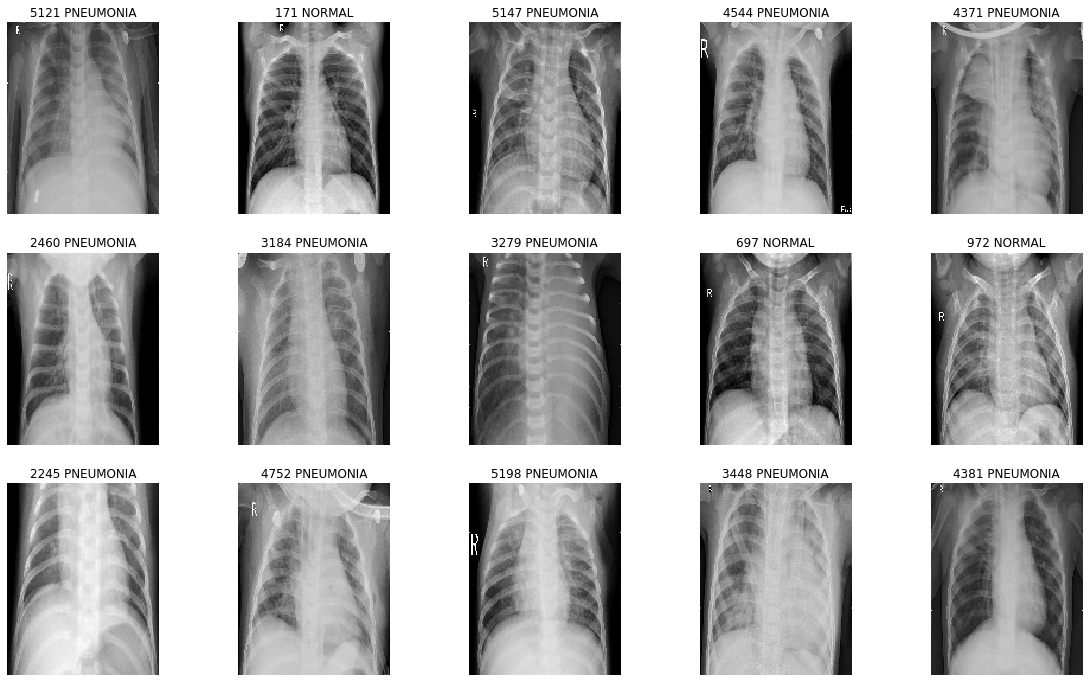

In [8]:
pltsize=4
row_images = 3
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))
#randomly print some sample images
for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0]-1)
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(sp.misc.toimage(X_train[i_rand]),cmap='gray')
    plt.title((str(i_rand) + " " + y_train[i_rand]))

##  Task 2：Train a logistic regression model to perform the classification task

In [9]:
# Change the shape of train_data to fit the input of logistic regression
# （sample_number,162，128）-->(sample_number,162*128)
nsamples, nx, ny = X_train.shape
X_train_wide = X_train.reshape((nsamples,nx*ny))
print(X_train.shape,X_train_wide.shape,y_train_num.shape)

# Train a logistic regression model
model2 = linear_model.LogisticRegression()
model2.fit(X_train_wide,y_train_num)

(5232, 162, 128) (5232, 20736) (5232,)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
# Change the shape of test_data and use the model to predict.
nsamples, nx, ny = X_test.shape
X_test_wide = X_test.reshape((nsamples,nx*ny))

# Make a set of predictions for the test data
y_test_pred = model2.predict(X_test_wide)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, y_test_pred)
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, y_test_pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, y_test_pred))

Accuracy: 0.7419871794871795
              precision    recall  f1-score   support

           0       0.94      0.33      0.49       234
           1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.83      0.66      0.66       624
weighted avg       0.80      0.74      0.70       624

Confusion matrix
[[ 78 156]
 [  5 385]]


## Task 3：Train a convolutional neural network model to recognise pneumonia in these images.

In [11]:
# Split train data and validation data
X_train_3, X_valid_3, y_train_3, y_valid_3 = train_test_split(X_train_wide, y_train_num, random_state=0, test_size = 0.20, train_size = 0.8)
X_train_part = X_train_3
y_train_part = y_train_3
print(X_train_3.shape,X_valid_3.shape)

(4185, 20736) (1047, 20736)


In [12]:
# Undersample the train data
under_sampling = RandomUnderSampler(random_state=0)
X_train_b,y_train_b = under_sampling.fit_resample(X_train_3, y_train_3)
print(np.bincount(y_train_b))

[1073 1073]


In [13]:
# Resize the data to (32,32)
def resize_to_input(train_data):    
    X_layer_data = np.ndarray((train_data.shape[0], 32, 32), dtype=np.float)

    for i, one_image in enumerate(train_data):
        one_image = cv2.resize(one_image, (32, 32), interpolation=cv2.INTER_CUBIC)  
        X_layer_data[i] = one_image
    return (X_layer_data)

In [14]:
def preprocessing(train_data,y_data):
    # Change the shape of train_data to fit the input of resize_to_input
    # （sample_number,162*128）-->(sample_number,162,128)
    nsamples, nxy = train_data.shape
    train_data = train_data.reshape((nsamples,162,128))
    # Resize the data to (sample_number,32,32)
    train_data = resize_to_input(train_data)
    # Change the shape of train_data to (sample_number,32,32,1)
    train_data = np.reshape(train_data,train_data.shape+(1,))
    # Convert class vectors to binary class matrices.
    y_data = keras.utils.to_categorical(y_data, num_classes)
    return (train_data,y_data)

(X_train_3, y_train_3) = preprocessing(X_train_3, y_train_3)
(X_valid_3, y_valid_3) = preprocessing(X_valid_3, y_valid_3)

Classic LeNet-5 model

In [59]:
model3=Sequential()
model3.add(Conv2D(6,(5,5),input_shape=[32, 32, 1], activation='tanh'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(16,(5,5),activation='tanh'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())
model3.add(Dense(120,activation="tanh"))
model3.add(Dense(84,activation="tanh"))
model3.add(Dense(2,activation="softmax"))
model3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_8 (Dense)              (None, 84)               

In [16]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data, so it's no need
# to worry about overfit.
best_weights_filepath = './best_weights_task3.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = model3.fit(X_train_3, y_train_3,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data = (X_valid_3, y_valid_3),
          shuffle=True,
          callbacks=[mcp])

Train on 4185 samples, validate on 1047 samples
Epoch 1/50
4185/4185 [==============================] - 20s 5ms/step - loss: 0.4457 - accuracy: 0.8024 - val_loss: 0.3051 - val_accuracy: 0.8634
Epoch 2/50
4185/4185 [==============================] - 1s 122us/step - loss: 0.2227 - accuracy: 0.9087 - val_loss: 0.1788 - val_accuracy: 0.9265
Epoch 3/50
4185/4185 [==============================] - 0s 75us/step - loss: 0.1439 - accuracy: 0.9434 - val_loss: 0.1376 - val_accuracy: 0.9436
Epoch 4/50
4185/4185 [==============================] - 0s 79us/step - loss: 0.1184 - accuracy: 0.9534 - val_loss: 0.1467 - val_accuracy: 0.9427
Epoch 5/50
4185/4185 [==============================] - 0s 67us/step - loss: 0.1007 - accuracy: 0.9599 - val_loss: 0.1167 - val_accuracy: 0.9551
Epoch 6/50
4185/4185 [==============================] - 0s 62us/step - loss: 0.0939 - accuracy: 0.9620 - val_loss: 0.1227 - val_accuracy: 0.9561
Epoch 7/50
4185/4185 [==============================] - 0s 64us/step - loss: 0.08

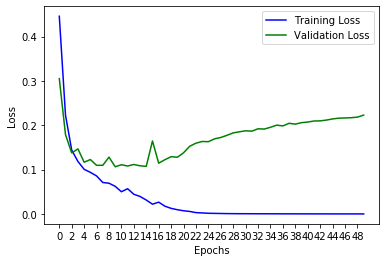

In [17]:
# print loss vs. epochs
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [18]:
X_test_b = resize_to_input(X_test)
print(X_test_b.shape)
X_test_b = np.reshape(X_test_b,X_test_b.shape+(1,))
print(X_test_b.shape)
model3.load_weights(best_weights_filepath)
pred = model3.predict_classes(X_test_b)

(624, 32, 32)
(624, 32, 32, 1)


In [19]:
# Print performance details
accuracy = metrics.accuracy_score(y_test_num, pred)
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

Accuracy: 0.7323717948717948
              precision    recall  f1-score   support

           0       0.94      0.31      0.46       234
           1       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.82      0.65      0.64       624
weighted avg       0.79      0.73      0.69       624

Confusion matrix
[[ 72 162]
 [  5 385]]


## Task 4：Use data augmentation techniques

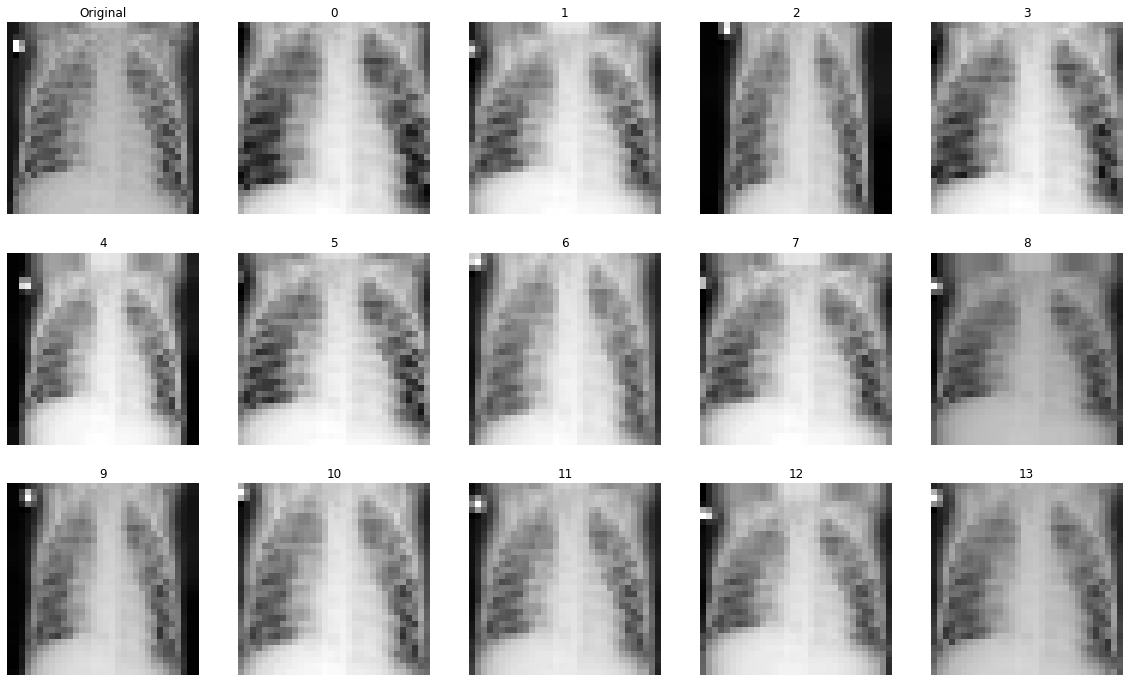

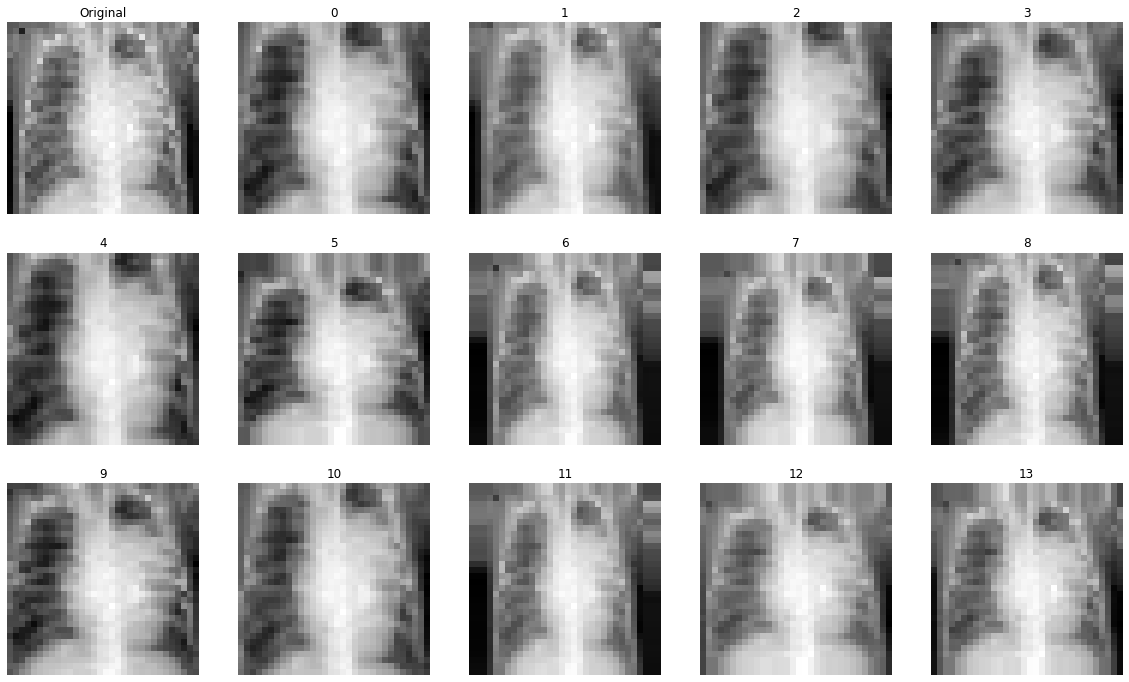

In [60]:
pltsize=4
row_images = 3
col_images = 5

# Flipping images horizontally or vertically is not appropriate as x-ray images 
# have a fixed frame of reference, so I choose  zoom_range to create 
#image gtenerator instance.
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=0,
    zoom_range=0.2)

# Fit parameters from data
datagen.fit(X_train_3)

# Print the sample data augmentation images
for idx in range(0, 2):
    # Plot the original image
    plt.figure(figsize=(col_images*pltsize, row_images*pltsize))
    plt.subplot(row_images,col_images,1)
    plt.axis('off')
    original_image = X_train_3[idx]
    plt.imshow(sp.misc.toimage(original_image.reshape(32, 32)),cmap='gray')
    plt.title("Original")
    # Plot the data augmentation images
    for i in range(row_images * col_images - 1):
        rand_trans = datagen.random_transform(X_train_3[idx])
        plt.subplot(row_images,col_images,i+2)
        plt.axis('off')
        plt.imshow(sp.misc.toimage(rand_trans.reshape(32, 32)),cmap='gray')
        plt.title(i)
    plt.show()                             

In [61]:
batch_size = 128
epochs = 100

# Set up the callback to save the best model based on validaion data, so it's no need
# to worry about overfit.
best_weights_filepath = './best_weights_task4.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = model3.fit_generator(datagen.flow(X_train_3, y_train_3, batch_size=batch_size),
          steps_per_epoch=len(X_train_3)/(batch_size*2),
          epochs=epochs,
          verbose = 1,
          validation_data = (X_valid_3, y_valid_3),
          shuffle=True,
          callbacks=[mcp])

Epoch 1/100
17/16 [===============================] - 0s 23ms/step - loss: 0.5609 - accuracy: 0.7169 - val_loss: 0.5192 - val_accuracy: 0.8023
Epoch 2/100
17/16 [===============================] - 0s 24ms/step - loss: 0.4532 - accuracy: 0.7840 - val_loss: 0.3503 - val_accuracy: 0.8558
Epoch 3/100
17/16 [===============================] - 0s 17ms/step - loss: 0.3356 - accuracy: 0.8582 - val_loss: 0.3224 - val_accuracy: 0.8672
Epoch 4/100
17/16 [===============================] - 0s 19ms/step - loss: 0.2850 - accuracy: 0.8774 - val_loss: 0.3208 - val_accuracy: 0.8777
Epoch 5/100
17/16 [===============================] - 0s 17ms/step - loss: 0.2423 - accuracy: 0.8994 - val_loss: 0.2189 - val_accuracy: 0.9131
Epoch 6/100
17/16 [===============================] - 0s 19ms/step - loss: 0.2675 - accuracy: 0.8856 - val_loss: 0.3221 - val_accuracy: 0.8682
Epoch 7/100
17/16 [===============================] - 0s 18ms/step - loss: 0.2508 - accuracy: 0.8883 - val_loss: 0.2441 - val_accuracy: 0.9083

Epoch 58/100
17/16 [===============================] - 0s 20ms/step - loss: 0.1211 - accuracy: 0.9508 - val_loss: 0.1405 - val_accuracy: 0.9436
Epoch 59/100
17/16 [===============================] - 0s 16ms/step - loss: 0.1147 - accuracy: 0.9560 - val_loss: 0.1505 - val_accuracy: 0.9408
Epoch 60/100
17/16 [===============================] - 0s 16ms/step - loss: 0.1171 - accuracy: 0.9476 - val_loss: 0.1388 - val_accuracy: 0.9446
Epoch 61/100
17/16 [===============================] - 0s 21ms/step - loss: 0.1491 - accuracy: 0.9407 - val_loss: 0.1463 - val_accuracy: 0.9370
Epoch 62/100
17/16 [===============================] - 0s 20ms/step - loss: 0.1150 - accuracy: 0.9551 - val_loss: 0.1508 - val_accuracy: 0.9331
Epoch 63/100
17/16 [===============================] - 0s 19ms/step - loss: 0.1188 - accuracy: 0.9545 - val_loss: 0.1367 - val_accuracy: 0.9436
Epoch 64/100
17/16 [===============================] - 0s 18ms/step - loss: 0.1329 - accuracy: 0.9532 - val_loss: 0.1756 - val_accuracy:

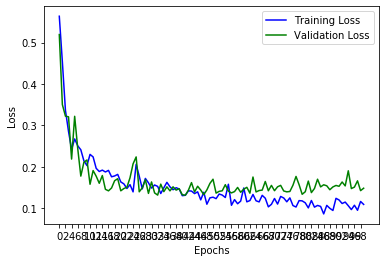

In [62]:
# Plot Loss vs. epochs
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [63]:
X_test_b = resize_to_input(X_test)
print(X_test_b.shape)
X_test_b = np.reshape(X_test_b,X_test_b.shape+(1,))
print(X_test_b.shape)
model3.load_weights(best_weights_filepath)
pred = model3.predict_classes(X_test_b)

(624, 32, 32)
(624, 32, 32, 1)


In [64]:
# Print performance details
accuracy = metrics.accuracy_score(y_test_num, pred)
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

Accuracy: 0.8621794871794872
              precision    recall  f1-score   support

           0       0.97      0.65      0.78       234
           1       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624

Confusion matrix
[[152  82]
 [  4 386]]


## Task 5：Use a pre-trained VGG16 model 

In [25]:
# Num class=2, so I set false to include_top
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [26]:
# Repeat the image (sample_num,32,32,1) to (sample_num,32,32,3)
X_train_triple = np.repeat(X_train_3, 3, axis=3)
X_valid_triple = np.repeat(X_valid_3, 3, axis=3)
# Print the summary of vgg16
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [27]:
for layer in vgg_conv.layers[:-2]:
    layer.trainable = False
# Unfreeze one of the convoluitonal layers in the network
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002890205C8C8> False
<keras.layers.convolutional.Conv2D object at 0x0000028902022E08> False
<keras.layers.convolutional.Conv2D object at 0x000002890C436CC8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000028906CE4588> False
<keras.layers.convolutional.Conv2D object at 0x0000028906D10208> False
<keras.layers.convolutional.Conv2D object at 0x00000289055F0BC8> False
<keras.layers.pooling.MaxPooling2D object at 0x000002890562A388> False
<keras.layers.convolutional.Conv2D object at 0x000002890562A488> False
<keras.layers.convolutional.Conv2D object at 0x00000289055D21C8> False
<keras.layers.convolutional.Conv2D object at 0x00000289055D0108> False
<keras.layers.pooling.MaxPooling2D object at 0x00000289055ED0C8> False
<keras.layers.convolutional.Conv2D object at 0x00000289055ED488> False
<keras.layers.convolutional.Conv2D object at 0x000002890BB13C88> False
<keras.layers.convolutional.Conv2D object at 0x000002890BAE3148> False
<ker

In [28]:
# I set include_top=False, so I add dense layers to the model
model5 = Sequential()
model5.add(vgg_conv)
model5.add(Flatten())
model5.add(Dense(4096, activation='relu'))
model5.add(Dense(4096, activation='relu'))
model5.add(Dense(2, activation='softmax'))
model5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

model5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 8194      
Total params: 33,605,442
Trainable params: 21,250,562
Non-trainable params: 12,354,880
_________________________________________________________________


In [30]:
batch_size = 128
epochs = 100

# Set up the callback to save the best model based on validaion data, so it's no need
# to worry about overfit.
best_weights_filepath = './best_weights_task5.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=0,
    zoom_range=0.2)

datagen.fit(X_train_triple)
print(X_train_triple.shape)
history = model5.fit_generator(datagen.flow(X_train_triple, y_train_3, batch_size=batch_size),
          steps_per_epoch=len(X_train_triple)/(batch_size*2),
          epochs=epochs,
          verbose = 1,
          validation_data = (X_valid_triple, y_valid_3),
          shuffle=True,
          callbacks=[mcp])

(4185, 32, 32, 3)
Epoch 1/100
17/16 [===============================] - 4s 249ms/step - loss: 1.1961 - accuracy: 0.7066 - val_loss: 0.3126 - val_accuracy: 0.8577
Epoch 2/100
17/16 [===============================] - 2s 107ms/step - loss: 0.3179 - accuracy: 0.8479 - val_loss: 0.2571 - val_accuracy: 0.8902
Epoch 3/100
17/16 [===============================] - 2s 104ms/step - loss: 0.2781 - accuracy: 0.8839 - val_loss: 0.2640 - val_accuracy: 0.8625
Epoch 4/100
17/16 [===============================] - 2s 107ms/step - loss: 0.2504 - accuracy: 0.8980 - val_loss: 0.1984 - val_accuracy: 0.9236
Epoch 5/100
17/16 [===============================] - 2s 104ms/step - loss: 0.1979 - accuracy: 0.9233 - val_loss: 0.1587 - val_accuracy: 0.9484
Epoch 6/100
17/16 [===============================] - 2s 106ms/step - loss: 0.1976 - accuracy: 0.9251 - val_loss: 0.1667 - val_accuracy: 0.9389
Epoch 7/100
17/16 [===============================] - 2s 105ms/step - loss: 0.2439 - accuracy: 0.8994 - val_loss: 0.22

17/16 [===============================] - 2s 107ms/step - loss: 0.1445 - accuracy: 0.9407 - val_loss: 0.1243 - val_accuracy: 0.9456
Epoch 58/100
17/16 [===============================] - 2s 104ms/step - loss: 0.1258 - accuracy: 0.9546 - val_loss: 0.1269 - val_accuracy: 0.9484
Epoch 59/100
17/16 [===============================] - 2s 104ms/step - loss: 0.1961 - accuracy: 0.9139 - val_loss: 0.1514 - val_accuracy: 0.9312
Epoch 60/100
17/16 [===============================] - 2s 105ms/step - loss: 0.1376 - accuracy: 0.9462 - val_loss: 0.1103 - val_accuracy: 0.9561
Epoch 61/100
17/16 [===============================] - 2s 106ms/step - loss: 0.1371 - accuracy: 0.9485 - val_loss: 0.1215 - val_accuracy: 0.9570
Epoch 62/100
17/16 [===============================] - 2s 104ms/step - loss: 0.1156 - accuracy: 0.9574 - val_loss: 0.1717 - val_accuracy: 0.9389
Epoch 63/100
17/16 [===============================] - 2s 105ms/step - loss: 0.1270 - accuracy: 0.9490 - val_loss: 0.1367 - val_accuracy: 0.947

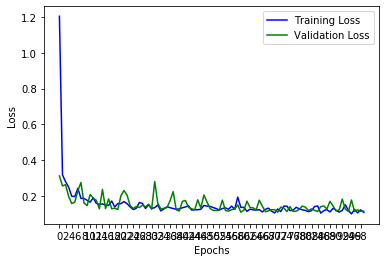

In [31]:
# Plot Loss vs. epochs
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [32]:
X_test_b = resize_to_input(X_test)
X_test_b = np.reshape(X_test_b,X_test_b.shape+(1,))
X_test_triple = np.repeat(X_test_b, 3, axis=3)
model5.load_weights(best_weights_filepath)

pred = model5.predict_classes(X_test_triple)

In [33]:
# Print performance details
accuracy = metrics.accuracy_score(y_test_num, pred)
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

Accuracy: 0.8397435897435898
              precision    recall  f1-score   support

           0       0.98      0.59      0.73       234
           1       0.80      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624

Confusion matrix
[[137  97]
 [  3 387]]


## Task 6: Compare the performance of the 4 models using the supplied test set.

In [65]:
# I choose the same train data to compare the performance of models.

print("Part2 model: logistic regression")
model2.fit(X_train_part,y_train_part)
y_test_pred = model2.predict(X_test_wide)
accuracy = metrics.accuracy_score(y_test_num, y_test_pred)
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, y_test_pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, y_test_pred))

print("Part3 model: classic LeNet-5 model")
model3.load_weights('./best_weights_task3.hdf5')
pred = model3.predict_classes(X_test_b)
accuracy = metrics.accuracy_score(y_test_num, pred)
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

print("Part4 model: classic LeNet-5 model with data augmentation")
model3.load_weights('./best_weights_task4.hdf5')
pred = model3.predict_classes(X_test_b)
accuracy = metrics.accuracy_score(y_test_num, pred)
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

print("Part5 model: pre-trained VGG16 model")
model5.load_weights('./best_weights_task5.hdf5')
pred = model5.predict_classes(X_test_triple)
accuracy = metrics.accuracy_score(y_test_num, pred)
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

Part2 model: logistic regression
Accuracy: 0.7451923076923077
              precision    recall  f1-score   support

           0       0.96      0.33      0.50       234
           1       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.75      0.70       624

Confusion matrix
[[ 78 156]
 [  3 387]]
Part3 model: classic LeNet-5 model
Accuracy: 0.7323717948717948
              precision    recall  f1-score   support

           0       0.94      0.31      0.46       234
           1       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.82      0.65      0.64       624
weighted avg       0.79      0.73      0.69       624

Confusion matrix
[[ 72 162]
 [  5 385]]
Part4 model: classic LeNet-5 model with data augmentation
Accuracy: 0.8621794871794872
              precision    recall  f1-score   support

### Reflection:
The most accurate model is classic LeNet-5 mode with data augmentation(Part4 model). Because of the use of undersampling and data augmentation, part4 model performs surely better than Part2 and Part3 model. Speaking of part5 model, it's only slightly worse than part4, because of the difference between structure of VGG16 and LeNet-5. Both VGG16 and LeNet is more likely to mispredict normal as pneumonia, it is more acceptable because mispredict pneumonia as normal may delay the patient's treatment.